A faire :
* Réécrire de manière clean la description de l'algorithme
* Travailler sur l'output de l'algo

# 1. Description of the algorithm (in natural language)

The approach of the article is "Having computed $q^∗\left(z;u,s;\hat{\theta}\right)$, we output three (key, value) pairs in the Mapper: $(u, q^∗)$, $(s, q^∗)$, and $(z, q^∗)$."

In the reduceByKey part however, we can only compute a sum on a couple of variables (e.g. $(u,s)$) and not on a single variable. So we can easily compute $N(z) = \sum_s\sum_u q^*(z;u,s)$ but not $N(z,s) = \sum_u q^*(z;u,s)$ or $\hat{p}(z,u)=\frac{\sum_s q^*(z;u,s)}{\sum_z\sum_s q^*(z;u,s)}$ ...


* Initialize :
 * document = 2 first columns of the data (remove the headline) --> co-occurences film-user
 * map ([u,s,z], random)


* ([s,z], q*) --> mapper1
* ([u,z], q*) --> mapper2

* reduceByKey N(z,s) : ([z,s], sum q* du mapper1) 
* map N(z,s)/N(z) : ([z,s], N(z,s)/sum_s N(z,s))
* reduceByKey p(z|u) : ([z,u] sum q^* du mapper 2)
* map p(z|u) : ([z,u] p(z|u)/ sum_z p(z|u))

* map q(z;u,s) : ([z,u,s], N(z,s)/N(z)$*$p(z|u))
* map q(z;u,s) : ([z,u,s], q(z;u,s)/sum_z q(z;u,s))

# 2. The algorithm

In [1]:
import pyspark
from numpy import random 

In [2]:
#pd.read_csv("ratings.csv").head(1000).to_csv("ratings_short.csv",sep=',',index=False)

In [3]:
sc = pyspark.SparkContext()

## 2.1. Running the 1st iteration of the algorithm step-by-step

In [4]:
# nb of 'clusters' is a broadcast variable (useful, but not necessary, when we do the cartesian product)
nb_z = sc.broadcast(3)

In [9]:
document = sc.textFile("ratings_short.csv")

In [10]:
# A parser for extracting the interresting information from the dataset.

def parseLine(line):
    ## Pour l'instant j'ai viré la headline à la mano
    ## To Do : virer la headline
    line = line.split(',')
    line = line[0]+','+line[1]
    return(line)

In [11]:
# for a click-log couple (u,s), create a tuple (u,s,z) for z in Z

def cartesianProd(us):
    to_return = []
    for z in range(nb_z.value):
        to_return += [us+','+str(z)]
    return(to_return)

In [12]:
# creation of the tuples (u,s,z ; q*)
q0 = document.map(parseLine).flatMap(cartesianProd).map(lambda usz : (usz,random.rand()))
q0.collect()[:3]

[('1,31,0', 0.5577684698618929),
 ('1,31,1', 0.056920865699559564),
 ('1,31,2', 0.44269576979826863)]

In [13]:
##### ********* M-step (computation of the N(s,z) & N(z) functions) ********

# return (s,z, N(s,z))
Nsz = q0.map(lambda q : (q[0].split(',')[1]+','+q[0].split(',')[2],q[1])).reduceByKey(lambda x,y : x+y)
print('(s,z, N(s,z)): \n', Nsz.collect()[:1],'\n')

# return (z, N(z)=∑N(s,z))
Nz = Nsz.map(lambda N : (N[0].split(',')[1], N[1])).reduceByKey(lambda x,y : x+y)
print('(z, N(z)): \n', Nz.collect()[:1],'\n')

# return (s,z, N(s,z)/N(z))
Nsz = Nsz.map(lambda x : (x[0].split(',')[1], (x[0].split(',')[0],x[1]))) #('0', ('31', 0.6602937910124607))
tmpN = Nsz.join(Nz) #('0', (('31', 0.6602937910124607), 501.224237413403))
Nsz_normalized = tmpN.map(lambda x : (x[1][0][0]+','+x[0], x[1][0][1]/x[1][1]))
print('(s,z, N(s,z)/N(z)): \n', Nsz_normalized.collect()[:1],'\n')

(s,z, N(s,z)): 
 [('31,0', 0.7591101461359397)] 

(z, N(z)): 
 [('0', 499.8122875887982)] 

(s,z, N(s,z)/N(z)): 
 [('31,0', 0.0015187904839195734)] 



In [14]:
##### ********* M-step (computation of the p(z|u) function) ********

# p~(z|u) is the un-normalized value of p(z|u), i.e. ∑p~(z|u) ≠ 1

# return (u,z, p~(z|u))
Puz = q0.map(lambda q : (q[0].split(',')[0]+','+q[0].split(',')[2],q[1])).reduceByKey(lambda x,y : x+y)
print('(u,z, p~(z|u)): \n', Puz.collect()[:1],'\n')

# return (u, ∑p~(z|u))
Pu = Puz.map(lambda p : (p[0].split(',')[0], p[1])).reduceByKey(lambda x,y : x+y)
print('(u, ∑p~(z|u)): \n', Pu.collect()[:1],'\n')

# return (u, z, p(z|u)=p_(z|u)/∑p_(z|u))
Puz = Puz.map(lambda x : (x[0].split(',')[0], (x[0].split(',')[1],x[1]))) #('1', ('1', 9.849132242962598))
tmpP = Puz.join(Pu) #('4', (('0', 104.52747209196086), 314.82837141455155))
Puz = tmpP.map(lambda x : (x[0]+','+x[1][0][0], x[1][0][1]/x[1][1]))
print('(u,z, p(z|u)): \n', Puz.collect()[:1],'\n')

(u,z, p~(z|u)): 
 [('1,1', 9.466391830615876)] 

(u, ∑p~(z|u)): 
 [('1', 31.653025049739647)] 

(u,z, p(z|u)): 
 [('4,0', 0.33588102274329146)] 



In [15]:
# Sanity check that check that ∑p(z|u) == 1
Puz.map(lambda x : (x[0].split(',')[0], x[1])).reduceByKey(lambda x,y : x+y).collect()[:5]

[('4', 1.0), ('10', 1.0), ('12', 1.0), ('3', 1.0), ('6', 0.9999999999999998)]

In [16]:
##### ********* E-step (computation of the q*(u,s;z) function) ********

# 1st pre-step: join q0(u,s;z) & p(u|z) on u & z - and forget old value of q*
tmpQ0 = q0.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[2] , x[0].split(',')[1])) #('4,0', 0.346651199923261)
tmpQ0 = tmpQ0.join(Puz) #('9,0', ('1', 0.3019536803179005))

# 2nd pre-step: join q0(u,s;z) & N(s,z)/N(z) on s & z
tmpQ0 = tmpQ0.map(lambda x : (x[1][0]+','+x[0].split(',')[1] ,\
                             (x[0].split(',')[0],x[1][1]))) #('1,0', ('9', 0.3019536803179005))
tmpQ0 = tmpQ0.join(Nsz_normalized) #('534,0', (('9', 0.3019536803179005), 7.06974580116717e-05))




# 1st step for computing q*(u,s;z) --> return ((u,s;z), N(s,z)/N(z)*p(u|z))
# q*~ = N(s,z)/N(z)*p(u|z) is the unormalized version of q* - i.e. ∑q*~ ≠ 1
tmpQ0 = tmpQ0.map(lambda x : (x[1][0][0]+','+x[0],\
                             x[1][0][1]*x[1][1]))
print('(u,s;z, N(s,z)/N(z)*p(u|z)): \n', tmpQ0.collect()[:1],'\n')

# 2nd step for computing q*(u,s;z) --> return ((u,s), ∑N(s,z)/N(z)*p(u|z))
sumTmpQ0 = tmpQ0.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],x[1])).reduceByKey(lambda x,y : x+y)
print('(u,s, ∑N(s,z)/N(z)*p(u|z)): \n', sumTmpQ0.collect()[:1],'\n')


# 3rd step for computing q*(u,s;z) --> return ((u,s,z), N(s,z)/N(z)*p(u|z)/{∑N(s,z)/N(z)*p(u|z))}
tmpQ0 = tmpQ0.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],\
                             (x[0].split(',')[2],x[1])))
tmpQ0 = tmpQ0.join(sumTmpQ0)
q1 = tmpQ0.map(lambda x : (x[0]+','+x[1][0][0], x[1][0][1]/x[1][1]))
print('(u,s;z, q*(u,s;z)): \n', q1.collect()[:1],'\n')

(u,s;z, N(s,z)/N(z)*p(u|z)): 
 [('9,534,0', 0.0005620811961998402)] 

(u,s, ∑N(s,z)/N(z)*p(u|z)): 
 [('12,608', 0.0025361783735922657)] 

(u,s;z, q*(u,s;z)): 
 [('10,2827,0', 0.2510003184506507)] 



In [17]:
# Sanity check that ∑q*(u,s;z)=∑p(z|u,s) == 1
q1.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],\
                   x[1])).reduceByKey(lambda x,y : x+y).collect()[:5]

[('10,2827', 1.0),
 ('3,2959', 1.0),
 ('3,296', 1.0),
 ('15,5', 1.0),
 ('12,1028', 0.9999999999999999)]

## 2.2. Looping through the algorithm

In [ ]:
# A parser for extracting the interresting information from the dataset.

def parseLine(line):
    ## Pour l'instant j'ai viré la headline à la mano
    ## To Do : virer la headline
    line = line.split(',')
    line = line[0]+','+line[1]
    return(line)

# for a click-log couple (u,s), create a tuple (u,s,z) for z in Z

def cartesianProd(us):
    to_return = []
    for z in range(nb_z.value):
        to_return += [us+','+str(z)]
    return(to_return)

In [ ]:
nb_z = sc.broadcast(3)
nb_iter = 10
document = sc.textFile("/Users/sachaizadi/Desktop/Projet\ DataBase\ Management/Notebooks/ratings_short.csv")

In [ ]:
###### Initialisation 
# creation of the tuples (u,s,z ; q*)
q = document.map(parseLine).flatMap(cartesianProd).map(lambda usz : (usz,random.rand()))
q.collect()[:3]

for k in range(nb_iter) :
    
    # *************************** M-step **************************
    # ********* computation of the N(s,z) & N(z) functions *********

    # return (s,z, N(s,z))
    Nsz = q.map(lambda Q : (Q[0].split(',')[1]+','+Q[0].split(',')[2],Q[1])).reduceByKey(lambda x,y : x+y)

    # return (z, N(z)=∑N(s,z))
    Nz = Nsz.map(lambda N : (N[0].split(',')[1], N[1])).reduceByKey(lambda x,y : x+y)

    # return (s,z, N(s,z)/N(z))
    Nsz = Nsz.map(lambda x : (x[0].split(',')[1], (x[0].split(',')[0],x[1])))
    tmpN = Nsz.join(Nz)
    Nsz_normalized = tmpN.map(lambda x : (x[1][0][0]+','+x[0], x[1][0][1]/x[1][1]))
    
    
    
    # ********* computation of the p(z|u) function *********
    # p~(z|u) is the un-normalized value of p(z|u), i.e. ∑p~(z|u) ≠ 1

    # return (u,z, p~(z|u))
    Puz = q.map(lambda Q : (Q[0].split(',')[0]+','+Q[0].split(',')[2],Q[1])).reduceByKey(lambda x,y : x+y)

    # return (u, ∑p~(z|u))
    Pu = Puz.map(lambda p : (p[0].split(',')[0], p[1])).reduceByKey(lambda x,y : x+y)

    # return (u, z, p(z|u)=p~(z|u)/∑p~(z|u))
    Puz = Puz.map(lambda x : (x[0].split(',')[0], (x[0].split(',')[1],x[1])))
    tmpP = Puz.join(Pu)
    Puz = tmpP.map(lambda x : (x[0]+','+x[1][0][0], x[1][0][1]/x[1][1]))
    
   
    
    
    
    # *************************** E-step **************************
    # ********* computation of the q*(u,s;z) function *********

    # 1st pre-step: join q(u,s;z) & p(u|z) on u & z - and forget old value of q*
    tmpQ = q.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[2] , x[0].split(',')[1]))
    tmpQ = tmpQ.join(Puz)

    # 2nd pre-step: join q0(u,s;z) & N(s,z)/N(z) on s & z
    tmpQ = tmpQ.map(lambda x : (x[1][0]+','+x[0].split(',')[1] ,\
                                 (x[0].split(',')[0],x[1][1])))
    tmpQ = tmpQ.join(Nsz_normalized)




    # 1st step for computing q*(u,s;z) --> return ((u,s;z), N(s,z)/N(z)*p(u|z))
    # q*~ = N(s,z)/N(z)*p(u|z) is the unormalized version of q* - i.e. ∑q*~ ≠ 1
    tmpQ = tmpQ.map(lambda x : (x[1][0][0]+','+x[0],\
                                 x[1][0][1]*x[1][1]))

    # 2nd step for computing q*(u,s;z) --> return ((u,s), ∑N(s,z)/N(z)*p(u|z))
    sumTmpQ = tmpQ.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],x[1])).reduceByKey(lambda x,y : x+y)

    # 3rd step for computing q*(u,s;z) --> return ((u,s,z), N(s,z)/N(z)*p(u|z)/{∑N(s,z)/N(z)*p(u|z))}
    tmpQ = tmpQ.map(lambda x : (x[0].split(',')[0]+','+x[0].split(',')[1],\
                                 (x[0].split(',')[2],x[1])))
    tmpQ = tmpQ.join(sumTmpQ)
    q = tmpQ.map(lambda x : (x[0]+','+x[1][0][0], x[1][0][1]/x[1][1]))
    
    # we need to collect at this point because otherwise it behaves like a recursive calling of rdds 
    # which may crash
    q = sc.parallelize(q.collect())

Generating recommendations:
$$ p(s\vert u;\theta) = \sum_{z=1}^L p(z\vert u)p(s\vert z)$$

In [58]:
rdd1 = sc.parallelize([(1,2),(1,3),(2,3),(2,4)])
rdd2 = sc.parallelize([(1,4),(1,5),(2,9),(2,0),(3,0)])

rdd1.join(rdd2).collect()

[(1, (2, 4)),
 (1, (2, 5)),
 (1, (3, 4)),
 (1, (3, 5)),
 (2, (3, 9)),
 (2, (3, 0)),
 (2, (4, 9)),
 (2, (4, 0))]

In [ ]:
# rdd = [('u,s',p(u|s))]

import numpy as np


rdd = []
for k in range (200) :
    rdd += [(str(np.random.randint(50))+','+str(np.random.randint(50)),np.random.rand())]

rdd = sc.parallelize(rdd)

In [117]:
# Classification p(u|s)≥threshold --> True

threshold = sc.broadcast(.5)

def prediction(train):
    return(rdd.map(lambda x : (x[0],x[1]>=threshold.value)))

print("prediction:",prediction(rdd).collect()[:3])

prediction: [('36,36', True), ('31,6', False), ('17,47', False)]


In [126]:
# Split in test and train

def splitTrainTest(document, alpha=0.1):
    train_test = document.randomSplit([1-alpha, alpha], seed = 42)
    train, test = test_train[0], test_train[1]
    
    # We need to check that film 's' in the test set is also in the train set (needed to evaluate our model)

    s_train = train.map(lambda x : x.split(',')[1])
    s_test = test.map(lambda x : x.split(',')[1])

    s_common = sc.broadcast(s_test.intersection(s_train).collect())

    # filter the test set :
    test = test.map(lambda x : (x.split(',')[0], x.split(',')[1], x.split(',')[2]))\
               .filter(lambda x : x[1] in s_common.value)\
               .map(lambda x : (x[0]+','+x[1],x[2]))
            
    return([train,test])


# returns 'u,s,score'
print("train:",splitTrainTest(document, alpha=0.1)[0].collect()[:3])
print("nb elements in train:",splitTrainTest(document, alpha=0.1)[0].count())
print("test:",splitTrainTest(document, alpha=0.1)[1].collect()[:3])
print("nb elements in test:",splitTrainTest(document, alpha=0.1)[1].count())

train: ['1,31,2.5,1260759144', '1,1029,3.0,1260759179', '1,1061,3.0,1260759182']
nb elements in train: 904
test: [('1,2193', '2.0'), ('2,50', '4.0'), ('2,410', '3.0')]
nb elements in test: 50


In [88]:
def accuracyTrain(prediction, train) :
    # predition doit être de cette forme-là : ('44,18', True)
    # train doit être de cette forme-là : ('44,18', random)
    
    # positive predictions
    pos = prediction.filter(lambda x : x[1])
    nb_pos = pos.count()
    nb_TP = pos.join(train).count()
    nb_FP = nb_pos - nb_TP
    
    #negatives predictions
    neg = prediction.filter(lambda x : not(x[1]))
    nb_neg = neg.count()
    nb_FN = neg.join(train).count()
    nb_TN = nb_neg - nb_FN
    
    # computing accuracy
    ACC = (nb_TP + nb_TN) / (nb_TP + nb_FP + nb_FN + nb_TN)
    return(ACC)

print(accuracyTrain(classifier,train))

0.445


In [114]:
def accuracyTest(prediction, train, test) :
    # predition doit être de cette forme-là : ('44,18', True)
    # test doit être de cette forme-là : ('44,18', random)
    
    # Remove from prediction the films already seen by users
    prediction = prediction.subtractByKey(train)
    
    
    # positive predictions
    pos = prediction.filter(lambda x : x[1])
    nb_pos = pos.count()
    nb_TP = pos.join(test).count()
    nb_FP = nb_pos - nb_TP
    
    #negatives predictions
    neg = prediction.filter(lambda x : not(x[1]))
    nb_neg = neg.count()
    nb_FN = neg.join(test).count()
    nb_TN = nb_neg - nb_FN
    
    # computing accuracy
    ACC = (nb_TP + nb_TN) / (nb_TP + nb_FP + nb_FN + nb_TN)
    return(ACC)

print(accuracyTest(classifier,train,test))

0.445


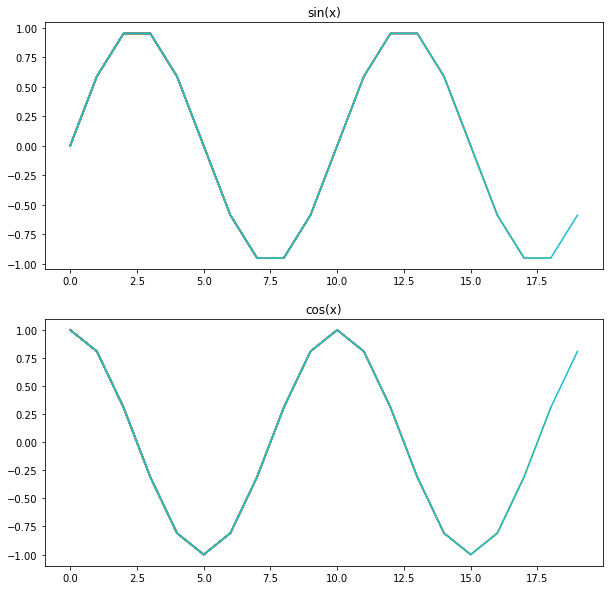

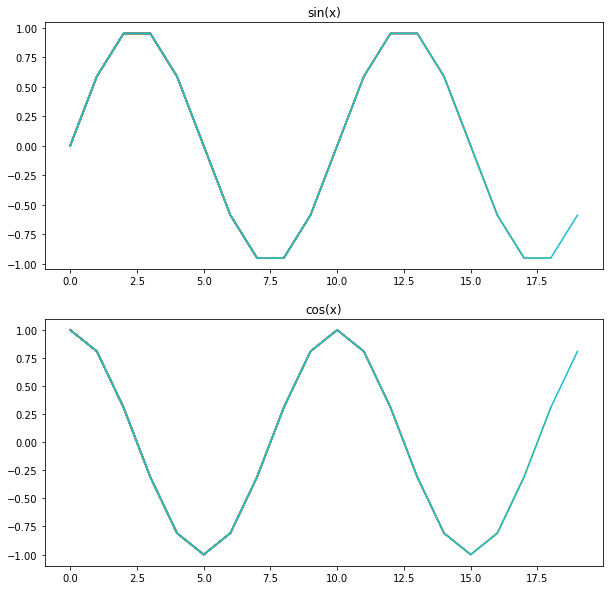

In [142]:
# Only for runing in local



%matplotlib inline
import time
import matplotlib.pyplot as plt
from IPython import display

plt.figure(figsize=(10,10))

to_plot1 = []
to_plot2 = []
x = []

for i in range(20):
    to_plot1 += [np.sin(2*np.pi*i/10)]
    to_plot2 += [np.cos(2*np.pi*i/10)]
    x += [i]
    
    plt.subplot(211)
    plt.plot(x,to_plot1)
    plt.title("sin(x)")
    
    plt.subplot(212)
    plt.plot(x,to_plot2)
    plt.title("cos(x)")
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.2)